In [1]:
# Cài đặt tất cả thư viện cần thiết cho pipeline
!pip install -q pandas scikit-learn matplotlib seaborn torch tabpfn pytorch-tabnet

CUDA is available. The models will run on the GPU.
Đang clone repository...

Kích thước tập train: (6954, 10)
Kích thước tập test: (1739, 10)

Đang tiền xử lý dữ liệu...
Tiền xử lý hoàn tất.
Kích thước dữ liệu train sau khi xử lý: (6954, 16)

--- Đang huấn luyện mô hình: TabPFN ---


tabpfn-v2-classifier-finetuned-zk73skhh.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

TabPFN - Accuracy: 0.8022, F1-score: 0.8085, ROC AUC: 0.8796

--- Đang huấn luyện mô hình: TabNet ---


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


TabNet - Accuracy: 0.7976, F1-score: 0.8053, ROC AUC: 0.8711


--- BẢNG SO SÁNH KẾT QUẢ CUỐI CÙNG ---
        Accuracy  F1-score   ROC AUC
TabPFN  0.802185  0.808463  0.879588
TabNet  0.797585  0.805310  0.871132


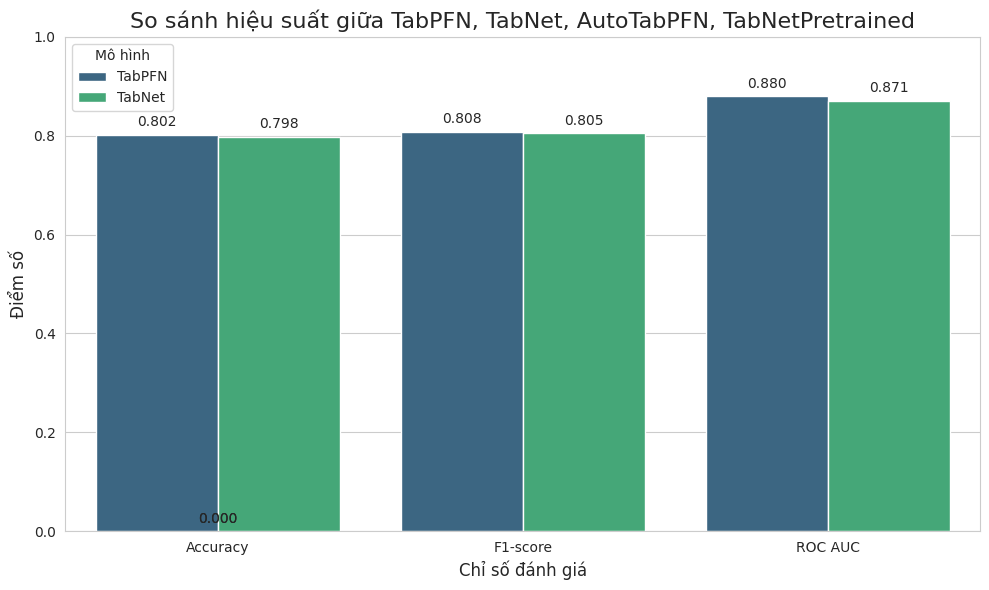

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess
import torch
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Models
from tabpfn import TabPFNClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

# Thiết lập định dạng cho plot và kiểm tra CUDA
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

if torch.cuda.is_available():
    device = 'cuda'
    print("CUDA is available. The models will run on the GPU.")
else:
    raise RuntimeError("CUDA is not available. This script is configured to run ONLY on CUDA.")

# --- Bước 1: Tải và Chuẩn bị Dữ liệu ---
if not os.path.isdir("ML251"):
    print("Đang clone repository...")
    subprocess.run(["git", "clone", "https://github.com/caoTayTang/ML251"])
else:
    print("Repository đã tồn tại.")

train_path = "ML251/data/spaceship-titanic/train.csv"
train_df = pd.read_csv(train_path)

X = train_df.drop(["Transported", "PassengerId", "Name", "Cabin"], axis=1)
y = train_df["Transported"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

categorical_features = X_train.select_dtypes(include=['object', 'boolean']).columns.tolist()
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()

print(f"\nKích thước tập train: {X_train.shape}")
print(f"Kích thước tập test: {X_test.shape}")

# --- Bước 2: Tiền xử lý Dữ liệu ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print("\nĐang tiền xử lý dữ liệu...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("Tiền xử lý hoàn tất.")
print(f"Kích thước dữ liệu train sau khi xử lý: {X_train_processed.shape}")

# --- Bước 3: Huấn luyện và Đánh giá các Mô hình ---
models = {
    "TabPFN": TabPFNClassifier(
        device=device
    ),
    "TabNet": TabNetClassifier(
        verbose=0, seed=42,
        device_name=device
    )
}



results = {}

for model_name, model in models.items():
    print(f"\n--- Đang huấn luyện mô hình: {model_name} ---")

    if model_name == "TabNetPretrained":
        model.fit(X_train_processed, y_train)
        y_pred = model.predict(X_test_processed)
        y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
    else:
        model.fit(X_train_processed, y_train)
        y_pred = model.predict(X_test_processed)
        y_pred_proba = model.predict_proba(X_test_processed)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results[model_name] = {
        'Accuracy': accuracy,
        'F1-score': f1,
        'ROC AUC': roc_auc
    }
    print(f"{model_name} - Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")


# --- Bước 4: So sánh Kết quả ---
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='ROC AUC', ascending=False)

print("\n\n--- BẢNG SO SÁNH KẾT QUẢ CUỐI CÙNG ---")
print(results_df.to_string())

results_df_melted = results_df.reset_index().melt(
    id_vars='index',
    var_name='Metric',
    value_name='Score'
)
results_df_melted.rename(columns={'index': 'Model'}, inplace=True)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=results_df_melted, x='Metric', y='Score', hue='Model', palette='viridis')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

plt.title('So sánh hiệu suất giữa TabPFN, TabNet, AutoTabPFN, TabNetPretrained', fontsize=16)
plt.xlabel('Chỉ số đánh giá', fontsize=12)
plt.ylabel('Điểm số', fontsize=12)
plt.ylim(0, 1.0)
plt.legend(title='Mô hình')
plt.tight_layout()
plt.show()
